In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import dgl
from torch_geometric.datasets.dblp import DBLP
import random
import torch
from torch import optim
import torch_geometric.utils.convert
from torch_geometric.data import HeteroData
from sklearn.feature_selection import VarianceThreshold
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import seaborn as sns
from collections import Counter
import itertools
import community as community_louvain
import matplotlib.cm as cm
import os
import glob
import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
data['conference'].pop('num_nodes')
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(data)
meta_g= g.metagraph()

Original DBLP dataset with all node features

In [3]:
dataset = DBLP(root='./dblp_data', transform=T.Constant(node_types='conference'))
data = dataset[0]
print(data)

HeteroData(
  author={
    x=[4057, 334],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 4231] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)


In [4]:
def feature_selection_var(X,threshold=0.0):
    sel = VarianceThreshold(threshold=(threshold * (1 - threshold)))
    fitted_X = sel.fit_transform(X)
    imp_feat = pd.DataFrame(fitted_X)

    return imp_feat

In [5]:
#all classes
# Feature selection for Author node
imp_feat_author = feature_selection_var(data['author'].x, threshold=0.948).iloc[:, : 50]
imp_feat_author

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
0     0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1     1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0   
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3     0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4052  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
4053  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4055  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4056  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

       43   44   45   46   47   48   49  
0     0.0  0.0  0.0  0.0  1.0  0.0  0.0  
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3     0.0  1.0  0.0  0.0  1.0  0.0  0.0  
4     0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...   ...  ...  ...  ...  ...  ...  ...  
4052  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
4053  0.0  1.0  0.0  0.0  0.0  0.0  0.0  
4054  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4055  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4056  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[4057 rows x 50 columns]

In [6]:
# Paper
paper = data['paper'].x.tolist()
df_paper = pd.DataFrame(paper)
imp_feat_paper = feature_selection_var(df_paper, threshold=0.9845).iloc[:, : 50]
imp_feat_paper

0    1    2    3    4    5    6    7    8    9   ...   40   41   42  \
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
2      0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
14323  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  2.0  0.0   
14324  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0   
14325  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
14326  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
14327  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0   

        43   44   45   46   47   48   49  
0      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4      0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
14323  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14324  0.0  0.0  0.0  0.0  0.0  0.0  1.0  
14325  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14326  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
14327  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[14328 rows x 50 columns]

In [7]:
data['author'].x = torch.tensor(imp_feat_author.values).to(dtype=torch.float32)
data['paper'].x = torch.tensor(imp_feat_paper.values).to(dtype=torch.float32)

In [8]:
data

HeteroData(
  author={
    x=[4057, 50],
    y=[4057],
    train_mask=[4057],
    val_mask=[4057],
    test_mask=[4057],
  },
  paper={ x=[14328, 50] },
  term={ x=[7723, 50] },
  conference={
    num_nodes=20,
    x=[20, 1],
  },
  (author, to, paper)={ edge_index=[2, 19645] },
  (paper, to, author)={ edge_index=[2, 19645] },
  (paper, to, term)={ edge_index=[2, 85810] },
  (paper, to, conference)={ edge_index=[2, 14328] },
  (term, to, paper)={ edge_index=[2, 85810] },
  (conference, to, paper)={ edge_index=[2, 14328] }
)

DBLP dataset with selected node features used for GNN training

In [9]:
#https://github.com/pyg-team/pytorch_geometric/blob/master/examples/hetero/hetero_conv_dblp.py
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['author'])

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['author'].train_mask
    loss = F.cross_entropy(out[mask], data['author'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)
        
@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)
    
    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['author'][split]
        acc = (pred[mask] == data['author'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs

In [10]:
#Reading from file the generated node features using diffusion
node_feat_path = '../../graph generator/diffusion models/sampled_features_diffusion/tabddpm/dblp/'
class0  = pd.DataFrame(np.load(node_feat_path + 'author0_tabddpm_variance50.npy',allow_pickle=True))
class1  = pd.DataFrame(np.load(node_feat_path + 'author1_tabddpm_variance50.npy',allow_pickle=True))
class2  = pd.DataFrame(np.load(node_feat_path + 'author2_tabddpm_variance50.npy',allow_pickle=True))
class3  = pd.DataFrame(np.load(node_feat_path + 'author3_tabddpm_variance50.npy',allow_pickle=True))
paper  = pd.DataFrame(np.load(node_feat_path + 'paper_tabddpm_variance50.npy',allow_pickle=True))
term  = pd.DataFrame(np.load(node_feat_path + 'term_tabddpm.npy',allow_pickle=True))

In [11]:
df_class0=class0.reset_index(drop=True)
df_class1=class1.reset_index(drop=True)
df_class2=class2.reset_index(drop=True)
df_class3=class3.reset_index(drop=True)


def get_node_features(G):
    nodes = []
    paper_node_features = []
    author_node_features = []
    author_class = []
    term_node_features = []
    conf_nodes = []
    for key, value in G.nodes(data=True):
        nodes.append(key)
        edges = [e for e in G.edges]
        
        node_id = G.nodes[key]["label"]
        node_type = G.nodes[key]["node_type"]
        
        if node_type == 0:
            paper_node = paper.loc[int(node_id), :].values.flatten().tolist()
            paper_node_features.append(paper_node)
            
        elif node_type == 1:
            node_class = random.choice([0, 1, 2, 3])
            
            if node_class == 0:
                author_node = df_class0.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(0)
                author_node_features.append(author_node)
                
            elif node_class == 1:
                author_node = df_class1.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(1)
                author_node_features.append(author_node)
                
            elif node_class == 2:
                author_node = df_class2.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(2)
                author_node_features.append(author_node)
                
            elif node_class == 3:
                author_node = df_class3.loc[int(node_id), :].values.flatten().tolist()
                author_class.append(3)
                author_node_features.append(author_node)

        elif node_type == 2:
            term_node = term.loc[int(node_id), :].values.flatten().tolist()
            term_node_features.append(term_node)
            
        elif node_type == 3:
            conf_nodes.append(node_id)

        author_node_features_df = pd.DataFrame(author_node_features)
        author_node_features_df['class'] = author_class
        paper_node_features_df = pd.DataFrame(paper_node_features)
        term_node_features_df = pd.DataFrame(term_node_features)
        conf_nodes_df = pd.DataFrame(conf_nodes)

    return nodes, edges, author_node_features_df, paper_node_features_df, term_node_features_df, conf_nodes_df

In [12]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [13]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [14]:
def get_node_type(node_type):
    if node_type == 1:
        return 'author'
    elif node_type == 0:
        return 'paper'
    elif node_type == 2:
        return 'term'
    elif node_type == 3:
        return 'conference'

In [15]:
#List of edges in metagraph of DBLP
list(meta_g.edges())

[('author', 'paper'),
 ('paper', 'author'),
 ('paper', 'conference'),
 ('paper', 'term'),
 ('conference', 'paper'),
 ('term', 'paper')]

In [16]:
def create_dataset(nodes,edges,author_df,paper_df,term_df,conf_df,node_id,df_graph):
    author = np.asarray(author_df.drop(columns=['class']))
    paper = np.asarray(paper_df)
    term = np.asarray(term_df)
    
    x_author = torch.tensor(author).to(dtype=torch.float32)
    y_author = torch.tensor(np.array(author_df["class"]), dtype=torch.long)
    x_paper = torch.tensor(paper).to(dtype=torch.float32)
    x_term = torch.tensor(term).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))

    author_to_paper = []
    paper_to_author = []
    paper_to_term = []
    paper_to_conf = []
    term_to_paper = []
    conf_to_paper = []
    remaining_edges = []

    class_dict = {'Paper':0, 'Author':1, 'Term':2,'Conference':3}

    for i in range(len(edges)):
        if (df_graph.iloc[int(source[i])]['class'] == class_dict['Author']) and \
        (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                author_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Author']):
                paper_to_author.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Term']):
                paper_to_term.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Paper']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Conference']):
                paper_to_conf.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Term']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                term_to_paper.append((int(source[i]),int(dest[i])))

        elif (df_graph.iloc[int(source[i])]['class'] == class_dict['Conference']) and \
            (df_graph.iloc[int(dest[i])]['class'] == class_dict['Paper']):
                conf_to_paper.append((int(source[i]),int(dest[i])))

        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(df_graph.iloc[int(source[i])]['class'])
            dest_node_type = get_node_type(df_graph.iloc[int(dest[i])]['class'])
            remaining_edges.append((source_node_type,dest_node_type))
            
            
    all_edges[node_id] = [*author_to_paper,*paper_to_author,*paper_to_term,*paper_to_conf,*term_to_paper,
                          *conf_to_paper]
            
    author = list(df_graph[df_graph['class'] == 1]['nodeId'])
    author = [int(i) for i in author]
    author_nodes_mapping = remap_indices(author)
    paper = list(df_graph[df_graph['class'] == 0]['nodeId'])
    paper = [int(i) for i in paper]
    paper_nodes_mapping = remap_indices(paper)
    term = list(df_graph[df_graph['class'] == 2]['nodeId'])
    term = [int(i) for i in term]
    term_nodes_mapping = remap_indices(term)
    conf = list(df_graph[df_graph['class'] == 3]['nodeId'])
    conf = [int(i) for i in conf]
    conf_nodes_mapping = remap_indices(conf)


    node_list = {}
    for d in [author_nodes_mapping, paper_nodes_mapping, term_nodes_mapping,conf_nodes_mapping]:
            node_list.update(d)            

    #Create Hetero Data      
    small_graph = HeteroData({'author':{'x': x_author, 'y':y_author}, 'paper':{'x': x_paper},
                              'term':{'x': x_term}, 'conference':{'num_nodes': conf_nodes.shape[0]}})

    if author_to_paper:
        edge_index_author_paper = preprocess_edges(author_to_paper,node_list)
        small_graph['author','to','paper'].edge_index = edge_index_author_paper

    if paper_to_author:
        edge_index_paper_author = preprocess_edges(paper_to_author,node_list)
        small_graph['paper','to','author'].edge_index = edge_index_paper_author

    if paper_to_term:
        edge_index_paper_term = preprocess_edges(paper_to_term,node_list)
        small_graph['paper','to','term'].edge_index = edge_index_paper_term

    if paper_to_conf:
        edge_index_paper_conf = preprocess_edges(paper_to_conf,node_list) 
        small_graph['paper','to','conference'].edge_index = edge_index_paper_conf

    if term_to_paper:
        edge_index_term_paper = preprocess_edges(term_to_paper,node_list) 
        small_graph['term','to','paper'].edge_index = edge_index_term_paper

    if conf_to_paper:
        edge_index_conf_paper = preprocess_edges(conf_to_paper,node_list)
        small_graph['conference','to','paper'].edge_index = edge_index_conf_paper

    transform = T.Constant(node_types='conference')
    small_graph = transform(small_graph)
    
    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
            
    return small_graph, remaining_edges

In [17]:
def evaluate_gnn(small_graph):
    with torch.no_grad():
        model.eval()
        small_graph= small_graph.to(device)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)

        return softmax.tolist()

In [18]:
graphs_path = '../../graph generator/diffusion models/sampled_graphs_diffusion/' 
print('Original no of graphs:',len([name for name in glob.iglob(graphs_path + 'dblp_10to15/*.gexf')]))

Original no of graphs: 1416


In [19]:
avg_max_pred_list = []
max_pred_list = []
graph_dict_list = []
softmax_dict_list = []
nodefeature_dict_list = []
all_edges_list = []
class_graphid_list = []

In [20]:
def get_max_pred(softmax_dict,i):
    #Getting the list of predictions for each class
    prob_class0_dict = {}
    prob_class1_dict = {}
    prob_class2_dict = {}
    prob_class3_dict = {}
    for nodeid in softmax_dict:
        list0= []
        list1= []
        list2= []
        list3= []
        if len(softmax_dict[nodeid]) > 0:
            list0= []
            list1= []
            list2= []
            list3= []
    
            for prob in softmax_dict[nodeid]:        
                list0.append(prob[0])        
                list1.append(prob[1]) 
                list2.append(prob[2]) 
                list3.append(prob[3])
    
         #Taking max probability of all nodes of each class in a graph
        if len(list0) != 0:
            prob_class0_dict[nodeid]=max(list0)
        if len(list1) != 0:    
            prob_class1_dict[nodeid]=max(list1)
        if len(list2) != 0:    
            prob_class2_dict[nodeid]=max(list2)
        if len(list3) != 0:    
            prob_class3_dict[nodeid]=max(list3)

    max_pred0 = max(prob_class0_dict.values())
    max_pred1 = max(prob_class1_dict.values())
    max_pred2 = max(prob_class2_dict.values())
    max_pred3 = max(prob_class3_dict.values())

    print('Run'+str(i), max_pred0, max_pred1, max_pred2, max_pred3)
    max_pred_list.append([max_pred0, max_pred1, max_pred2, max_pred3])

    graph_dict_list.append(graph_dict)
    all_edges_list.append(all_edges)
    softmax_dict_list.append(softmax_dict)
    nodefeature_dict_list.append(nodefeature_dict)
    
    avg_max_pred = (max_pred0+max_pred1+max_pred2+max_pred3)/4
    avg_max_pred_list.append(avg_max_pred)
    
    class0_graphid = max(prob_class0_dict, key=prob_class0_dict.get)
    class1_graphid = max(prob_class1_dict, key=prob_class1_dict.get)
    class2_graphid = max(prob_class2_dict, key=prob_class2_dict.get)
    class3_graphid = max(prob_class3_dict, key=prob_class3_dict.get)

    class_graphid_list.append([class0_graphid,class1_graphid,class2_graphid,class3_graphid])

In [21]:
for i in range(0,10):     

    model = HeteroGNN(data.metadata(), hidden_channels=64, out_channels=4,
                  num_layers=2)
    
    #device =  'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data, model = data.to(device), model.to(device)
    
    with torch.no_grad():  # Initialize lazy modules.
        out = model(data.x_dict, data.edge_index_dict)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)
    
    best_val_acc = 0
    start_patience = patience = 100
    for epoch in range(1, 500):
        loss = train()
        train_acc, val_acc, test_acc = test()
        if epoch%200==0:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
              f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')
    
        if best_val_acc <= val_acc:
            patience = start_patience
            best_val_acc = val_acc
        else:
            patience -= 1
    
        if patience <= 0:
            print('Stopping training as validation accuracy did not improve '
                  f'for {start_patience} epochs')
            break

        
    all_edges = {}
    softmax_dict = {}
    nodefeature_dict = {}
    graph_dict = {}

    #Read from file the synthetic graphs generated using diffusion to evaluate the trained GNN on the graphs
    for filepath in glob.iglob(graphs_path + 'dblp_10to15/*.gexf'):
        
        graph = nx.read_gexf(filepath)
    
        filename = os.path.basename(filepath)
        graph_id= filename.split('.')[0]
    
        nodeId_list = []
        node_type_list = []
    
        for key, value in graph.nodes(data=True):
            nodeId_list.append(key)
            node_type_list.append(value['node_type'])
     
        df_graph = pd.DataFrame()
        df_graph["nodeId"] = nodeId_list
        df_graph["class"] = node_type_list
      
    
        nodes,edges,author_node_features,paper_node_features,term_node_features,conf_nodes= get_node_features(graph)
        small_graph_data, removed_edges = create_dataset(nodes,edges,
                                  author_node_features,paper_node_features,
                                  term_node_features,conf_nodes,graph_id,df_graph)
        
    
        if (small_graph_data['author'].x.nelement()!=0) and \
        (small_graph_data['paper','to','author']) and \
        (small_graph_data['author','to','paper']) and \
        (small_graph_data['paper','to','conference']) and \
        (small_graph_data['paper','to','term']):
            
            softmax = evaluate_gnn(small_graph_data)
            softmax_dict[graph_id] = softmax
            nodefeature_dict[graph_id]={'author':small_graph_data['author'].x,
                                             'paper':small_graph_data['paper'].x,
                                             'term':small_graph_data['term'].x}
            graph_dict[graph_id]=df_graph
    
    print("No. of graphs evaluated: ",len(softmax_dict))

    get_max_pred(softmax_dict,i)


Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run0 1.0 0.9995896220207214 0.9998618364334106 0.9675466418266296
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run1 1.0 0.9966461062431335 0.9999874830245972 0.9911448359489441
Epoch: 200, Loss: 0.0068, Train: 1.0000, Val: 0.7425, Test: 0.7562
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run2 0.9999997615814209 0.9828238487243652 0.9998074173927307 0.9995751976966858
Epoch: 200, Loss: 0.0064, Train: 1.0000, Val: 0.7350, Test: 0.7581
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run3 1.0 0.9978508949279785 0.9999780654907227 0.9957068562507629
Stopping training as validation accuracy did not improve for 100 epochs
No. of graphs evaluated:  231
Run4 1.0 0.9954540729522705 0.9999758005142212 0.9883310198783875
Stopping tr

In [22]:
avg_max_pred_list

[0.9917495250701904,
 0.9969446063041687,
 0.9955515563488007,
 0.998383954167366,
 0.9959402233362198,
 0.9987784028053284,
 0.9979521930217743,
 0.995624229311943,
 0.9998470097780228,
 0.9980431348085403]

In [23]:
print('Mean',np.mean(avg_max_pred_list))

Mean 0.9968814834952354


In [24]:
print('Standard Deviation',np.std(avg_max_pred_list))

Standard Deviation 0.0021845426646330593


In [25]:
m = max(avg_max_pred_list)
index = avg_max_pred_list.index(m)
index

8

In [26]:
def plot_graph(graphid, max_pred,nodetype,edges,graph):

    classes = []
    G = nx.Graph(edges)
    df_graph = graph_dict[graphid]
    
    for g in G.nodes():      
        if df_graph.loc[g]['class'] == 0:
            classes.append(0)
        if df_graph.loc[g]['class'] == 1:
            classes.append(1)
        if df_graph.loc[g]['class'] == 2:
            classes.append(2)
        if df_graph.loc[g]['class'] == 3:
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(G, dict(zip(G.nodes(), classes)), 'class')
    
    print('Number of nodes: ',G.number_of_nodes())
    print('graph id: ',graphid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(G, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in G.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

In [27]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [28]:
plt.rcParams.update({'axes.ymargin': 0.2})

In [29]:
def count_plot(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('feature values',fontsize=30)
    plt.ylabel('feature count',fontsize=30)

    plt.show()

In [30]:
def plot_imp_feature(feat_list):
    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(x=0,ax=ax,data=pd.DataFrame(feat_list),width=0.3)
    for i in ax.containers:
        ax.bar_label(i,fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel('feature values',fontsize=30)
    plt.ylabel('no. of samples',fontsize=30)

    plt.show()

In [31]:
class0_graphid = class_graphid_list[index][0]
class1_graphid = class_graphid_list[index][1]
class2_graphid = class_graphid_list[index][2]
class3_graphid = class_graphid_list[index][3]

In [32]:
max_pred0 = max_pred_list[index][0]
max_pred1 = max_pred_list[index][1]
max_pred2 = max_pred_list[index][2]
max_pred3 = max_pred_list[index][3]

In [33]:
all_edges = all_edges_list[index]

In [34]:
graph_dict = graph_dict_list[index]

In [35]:
softmax_dict = softmax_dict_list[index]

In [36]:
nodefeature_dict = nodefeature_dict_list[index]

Plotting explanation graph and node features for each class of Author node

Node colors:

Paper - Blue

Author - Red

Term - Darkgreen

Conference - Orange

Number of nodes:  15
graph id:  graph1414
Max pred probability for class 0 is 1.0


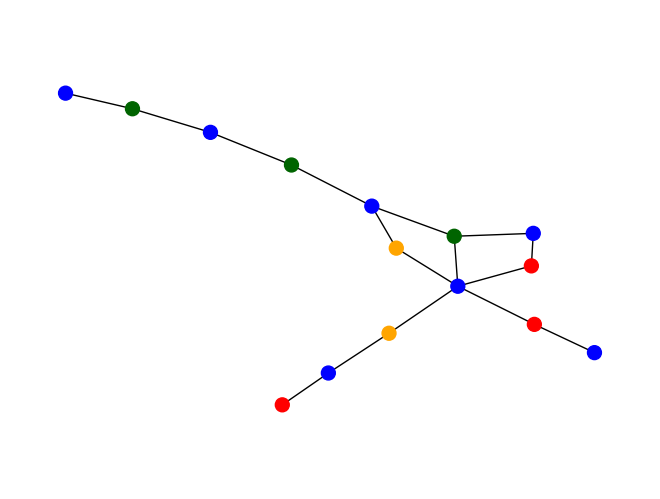

In [37]:
explanation_graph0 = plot_graph(class0_graphid, max_pred0, 0, all_edges[class0_graphid],graph_dict[class0_graphid])

In [38]:
ind= index_2d(softmax_dict[class0_graphid], max_pred0)[0]
list0= nodefeature_dict[class0_graphid]['author'].cpu().numpy()[ind]
Counter(list0)

Counter({0.0: 48, 1.0: 2})

In [39]:
print(list0)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0.]


In [40]:
index_2d(softmax_dict[class0_graphid], max_pred0)

(2, 0)

In [41]:
count_plot(list0)

In [42]:
explanation_graph1 = plot_graph(class1_graphid, max_pred1, 1, all_edges[class1_graphid],graph_dict[class1_graphid])

Number of nodes:  14
graph id:  graph1170
Max pred probability for class 1 is 0.9996615648269653


In [43]:
ind= index_2d(softmax_dict[class1_graphid], max_pred1)[0]
list1= nodefeature_dict[class1_graphid]['author'].cpu().numpy()[ind]
Counter(list1)

Counter({0.0: 48, 1.0: 2})

In [44]:
print(list1)

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


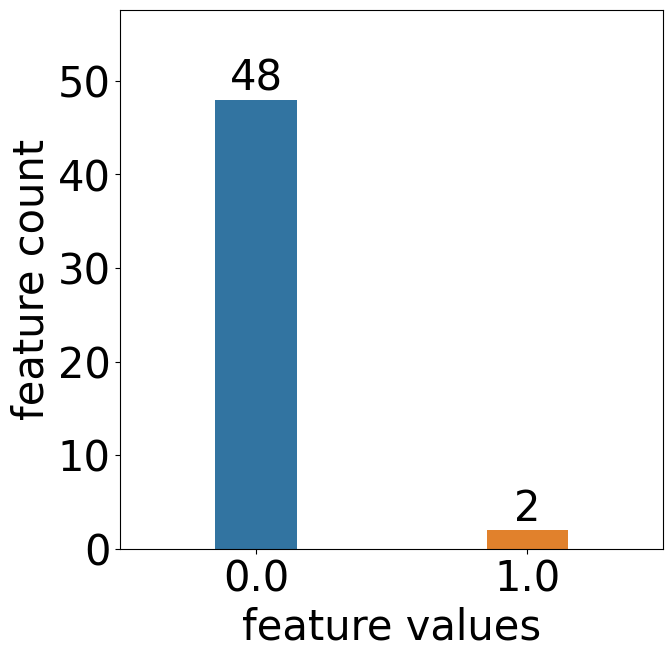

In [45]:
count_plot(list1)

In [46]:
explanation_graph2 = plot_graph(class2_graphid, max_pred2, 2, all_edges[class2_graphid],graph_dict[class2_graphid])

Number of nodes:  11
graph id:  graph246
Max pred probability for class 2 is 0.999957799911499


In [47]:
ind= index_2d(softmax_dict[class2_graphid], max_pred2)[0]
list2= nodefeature_dict[class2_graphid]['author'].cpu().numpy()[ind]
Counter(list2)

Counter({0.0: 26, 1.0: 24})

In [48]:
print(list2)

[1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0.]


In [49]:
count_plot(list2)

Number of nodes:  15
graph id:  graph1190
Max pred probability for class 3 is 0.9997686743736267


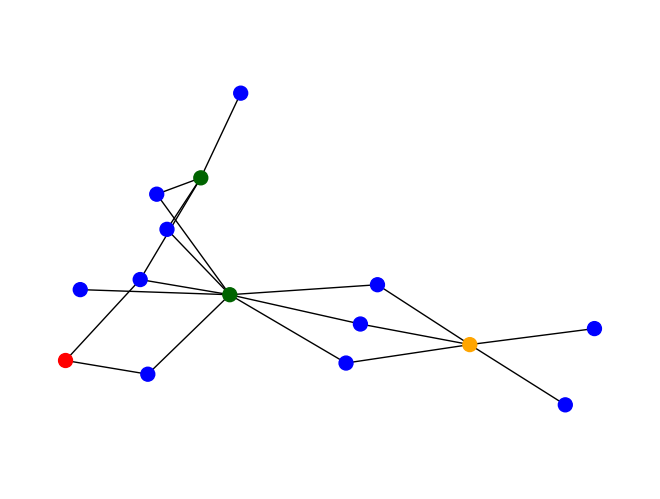

In [50]:
explanation_graph3 = plot_graph(class3_graphid, max_pred3, 3, all_edges[class3_graphid],graph_dict[class3_graphid])

In [51]:
ind= index_2d(softmax_dict[class3_graphid], max_pred3)[0]
list3= nodefeature_dict[class3_graphid]['author'].cpu().numpy()[ind]
Counter(list3)

Counter({0.0: 33, 1.0: 17})

In [52]:
print(list3)

[0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0.]


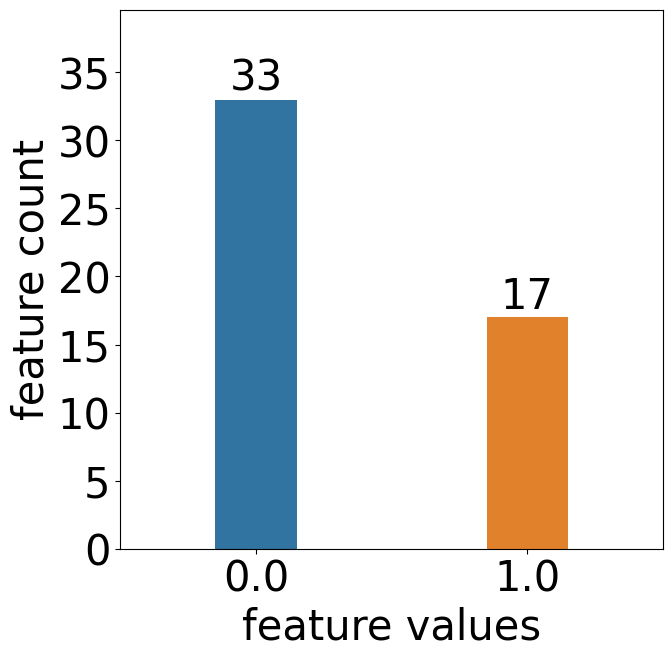

In [53]:
count_plot(list3)

In [54]:
def print_stat_cont_features(df):
    print('mean',df.stack().mean())
    print('std dev',df.stack().std())

In [55]:
def plot_node_feat(imp_feat):
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show()  

In [56]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat

In [57]:
#Term Feature Statistics
term0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['term'].cpu().numpy())
print_stat_cont_features(term0_df)

mean -0.07168741
std dev 0.64616525


In [58]:
plot_node_feat(term0_df)

In [59]:
term1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['term'].cpu().numpy())
print_stat_cont_features(term1_df)

mean 0.110735044
std dev 0.6022189


In [60]:
plot_node_feat(term1_df)

In [61]:
term2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['term'].cpu().numpy())
print_stat_cont_features(term2_df)

mean 0.026998188
std dev 0.66843355


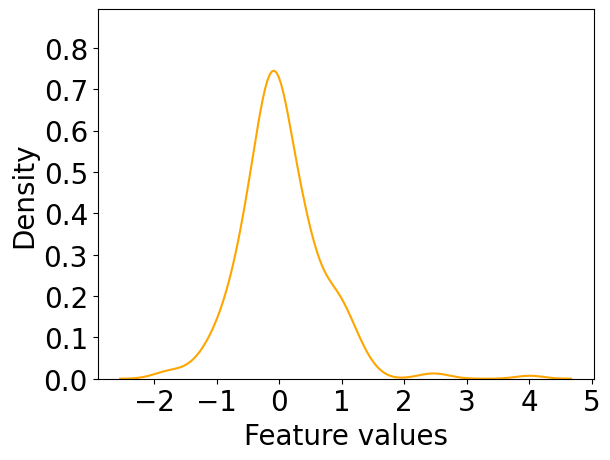

In [62]:
plot_node_feat(term2_df)

In [63]:
term3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['term'].cpu().numpy())
print_stat_cont_features(term3_df)

mean -0.100459576
std dev 0.6991457


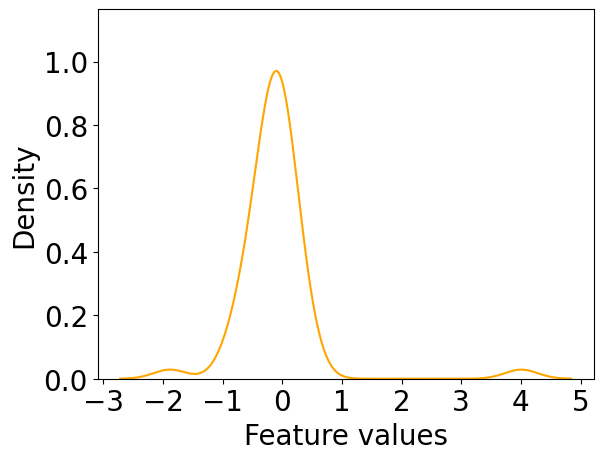

In [64]:
plot_node_feat(term3_df)

In [65]:
#Paper Features
paper0_df = pd.DataFrame(nodefeature_dict[class0_graphid]['paper'].cpu().numpy())

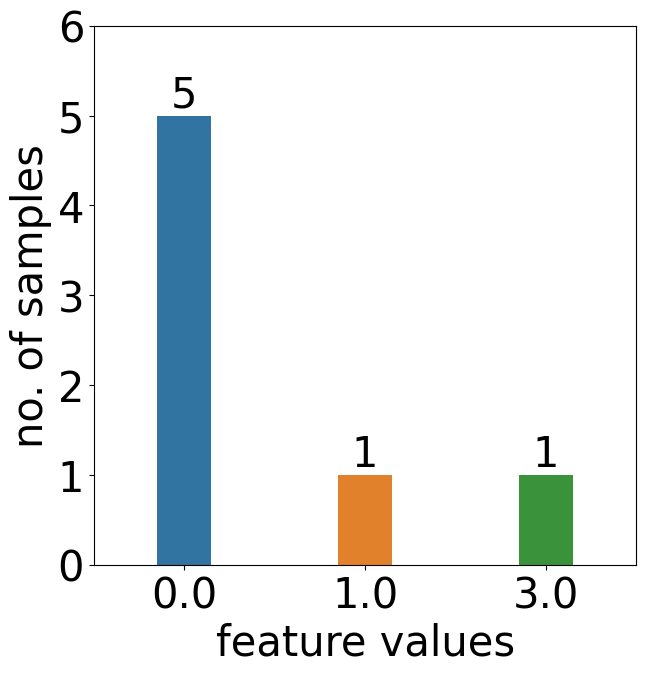

In [66]:
imp_paper_feat0=feature_selection(paper0_df)
plot_imp_feature(imp_paper_feat0.values.tolist())

In [67]:
paper1_df = pd.DataFrame(nodefeature_dict[class1_graphid]['paper'].cpu().numpy())

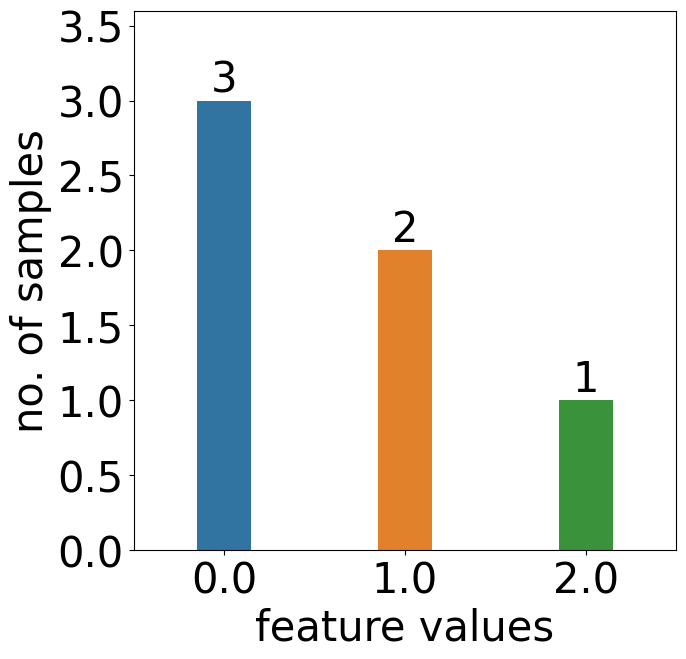

In [68]:
imp_paper_feat1=feature_selection(paper1_df)
plot_imp_feature(imp_paper_feat1.values.tolist())

In [69]:
paper2_df = pd.DataFrame(nodefeature_dict[class2_graphid]['paper'].cpu().numpy())

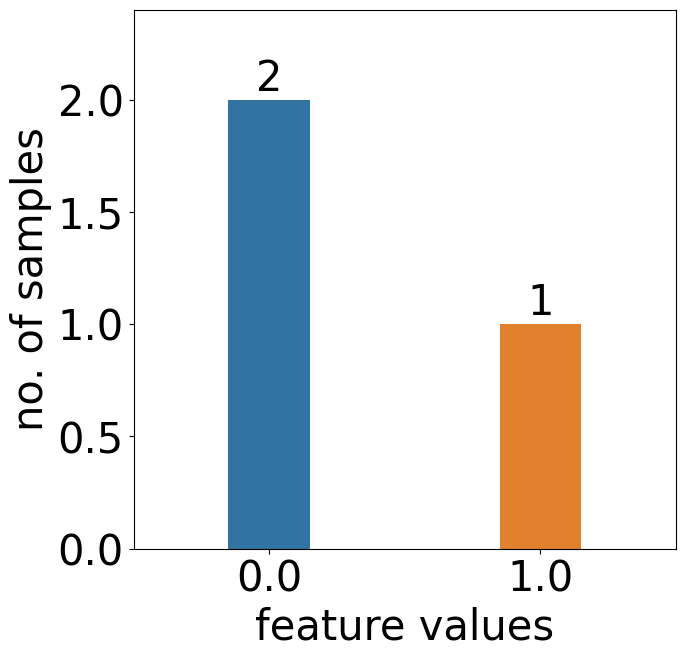

In [70]:
imp_paper_feat2=feature_selection(paper2_df)
plot_imp_feature(imp_paper_feat2.values.tolist())

In [71]:
paper3_df = pd.DataFrame(nodefeature_dict[class3_graphid]['paper'].cpu().numpy())

In [72]:
imp_paper_feat3=feature_selection(paper3_df)
plot_imp_feature(imp_paper_feat3.values.tolist())

In [73]:
motifs_path = 'motif_pytorch_real/dblp_10to15/'
files_motif = os.listdir(motifs_path)

In [74]:
for index_m, file_m in enumerate(files_motif):
    filepath_m = os.path.join(motifs_path, file_m)
    print(filepath_m)

motif_pytorch_real/dblp_10to15/motif_real_10_0.gexf
motif_pytorch_real/dblp_10to15/motif_real_10_1.gexf
motif_pytorch_real/dblp_10to15/motif_real_10_2.gexf
motif_pytorch_real/dblp_10to15/motif_real_10_3.gexf
motif_pytorch_real/dblp_10to15/motif_real_10_4.gexf
motif_pytorch_real/dblp_10to15/motif_real_11_0.gexf
motif_pytorch_real/dblp_10to15/motif_real_11_1.gexf
motif_pytorch_real/dblp_10to15/motif_real_11_2.gexf
motif_pytorch_real/dblp_10to15/motif_real_11_3.gexf
motif_pytorch_real/dblp_10to15/motif_real_11_4.gexf
motif_pytorch_real/dblp_10to15/motif_real_12_0.gexf
motif_pytorch_real/dblp_10to15/motif_real_12_1.gexf
motif_pytorch_real/dblp_10to15/motif_real_12_2.gexf
motif_pytorch_real/dblp_10to15/motif_real_12_3.gexf
motif_pytorch_real/dblp_10to15/motif_real_12_4.gexf
motif_pytorch_real/dblp_10to15/motif_real_13_0.gexf
motif_pytorch_real/dblp_10to15/motif_real_13_1.gexf
motif_pytorch_real/dblp_10to15/motif_real_13_2.gexf
motif_pytorch_real/dblp_10to15/motif_real_13_3.gexf
motif_pytorc

In [75]:
def get_avg_fidelity(graphid_list):
    class_avg_fidelity = []
    for graphid in graphid_list:
        expln_graph = nx.Graph(all_edges[graphid])
        edges = all_edges_list[i][graphid]
        expln_graph = nx.Graph(edges)

        fid_score_list = []       
        for index_m, file_m in enumerate(files_motif):
            filepath_m = os.path.join(motifs_path, file_m)

            motif_graph = nx.read_gexf(filepath_m)

            GM = nx.algorithms.isomorphism.GraphMatcher(expln_graph,motif_graph)
            x = 1 if GM.subgraph_is_isomorphic() else 0    
            fid_score_list.append(x)

        class_avg_fidelity.append(np.mean(fid_score_list))

    return np.mean(class_avg_fidelity) 

In [76]:
avg_fidelity_list = []

for i in range(0,10):
    avg_fidelity = get_avg_fidelity(class_graphid_list[i])

    print('Run'+str(i),avg_fidelity)
    avg_fidelity_list.append(avg_fidelity)
print('Mean',np.mean(avg_fidelity_list))

Run0 0.7166666666666666
Run1 0.7
Run2 0.7666666666666666
Run3 0.7083333333333333
Run4 0.65
Run5 0.7749999999999999
Run6 0.7250000000000001
Run7 0.7333333333333334
Run8 0.7666666666666667
Run9 0.75
Mean 0.7291666666666667


In [77]:
print('Standard Deviation',np.std(avg_fidelity_list))

Standard Deviation 0.03618048891015401
